# GeoTracks — Прототип аналитики (Кейс 2)
Этот ноутбук строит три визуализации по обезличенным геотрекам: 
1) Heatmap плотности поездок
2) Heatmap средней скорости (узкие места)
3) Маршруты с аномалиями скорости

**Примечание:** в датасете нет реального времени, поэтому почасовую динамику не строим.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/geo_locations_astana_hackathon.csv')

# Приводим типы
for col in ['lat','lng','spd','azm','alt']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['lat','lng']).copy()

df.head()

,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000


## 1) Heatmap плотности поездок

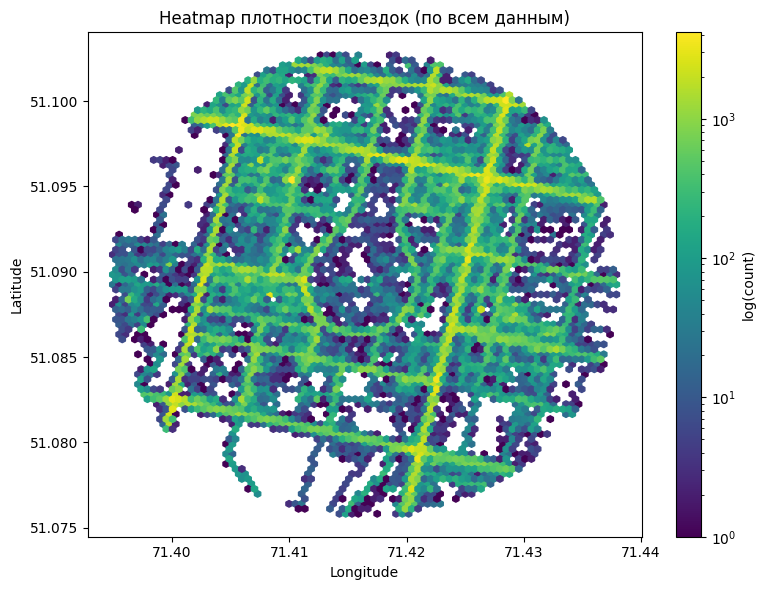

In [2]:
plt.figure(figsize=(8,6))
hb = plt.hexbin(df['lng'], df['lat'], gridsize=80, bins='log')
plt.colorbar(hb, label="log(count)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Heatmap плотности поездок (по всем данным)")
plt.tight_layout()
plt.show()

## 2) Heatmap средней скорости (узкие места)
Если в данных нет `spd`, этот раздел можно пропустить.

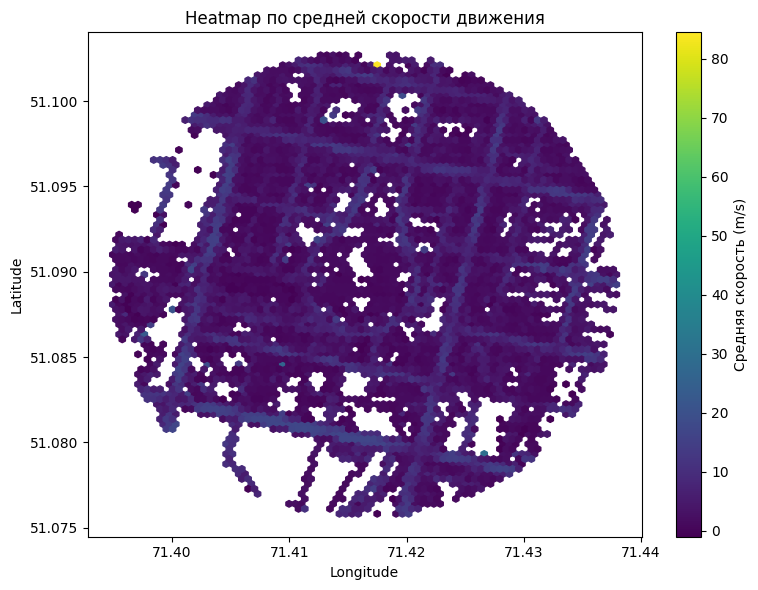

In [3]:
if 'spd' in df.columns:
    df_spd = df.dropna(subset=['spd']).copy()
    if len(df_spd) > 0:
        plt.figure(figsize=(8,6))
        hb2 = plt.hexbin(df_spd['lng'], df_spd['lat'], C=df_spd['spd'],
                         reduce_C_function=np.mean, gridsize=80)
        plt.colorbar(hb2, label="Средняя скорость (m/s)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Heatmap по средней скорости движения")
        plt.tight_layout()
        plt.show()
    else:
        print("Колонка 'spd' есть, но все значения NaN — пропускаем визуализацию.")
else:
    print("Колонка 'spd' отсутствует — пропускаем визуализацию.")

## 3) Маршруты с аномалиями скорости

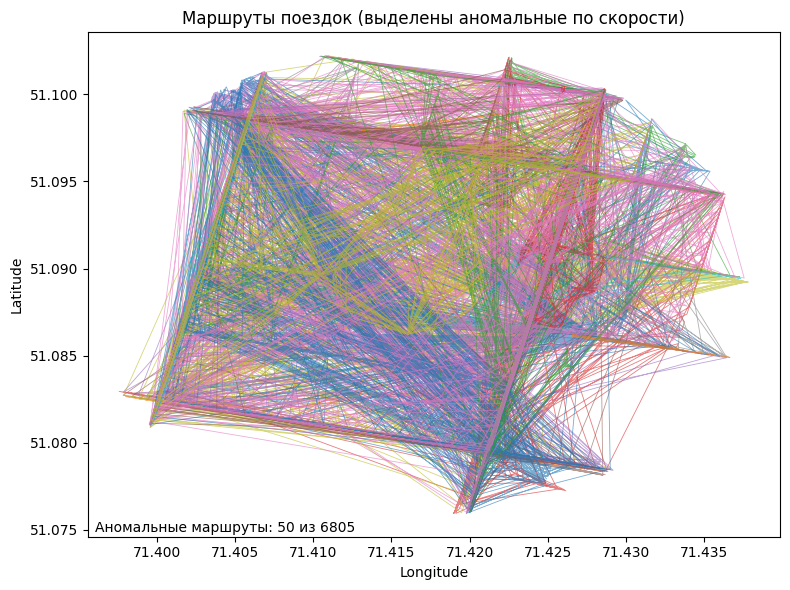

In [4]:
# Если нет randomized_id, присвоим всем одну группу для демонстрации
if 'randomized_id' not in df.columns:
    df['randomized_id'] = 0

# Порог выбросов по скорости (глобальные перцентили)
if 'spd' in df.columns:
    q_low, q_high = df['spd'].quantile([0.01, 0.99])
else:
    q_low, q_high = np.nan, np.nan

def is_outlier_speed(s):
    if np.isnan(q_low) or np.isnan(q_high):
        return pd.Series(False, index=s.index)
    return (s < q_low) | (s > q_high)

df['spd_outlier'] = is_outlier_speed(df['spd']) if 'spd' in df.columns else False

route_stats = (df.groupby('randomized_id')
                 .agg(points=('lat','size'), outliers=('spd_outlier','mean'))
                 .reset_index())

anomalous_ids = set(route_stats[(route_stats['outliers'] > 0.2) & (route_stats['points'] > 30)]['randomized_id'].values)

# Отобразим до 60 маршрутов
sample_ids = list(df['randomized_id'].drop_duplicates().sample(min(60, df['randomized_id'].nunique()), random_state=42).values)

plt.figure(figsize=(8,6))
for rid in sample_ids:
    seg = df[df['randomized_id'] == rid][['lat','lng']].dropna()
    if len(seg) < 2:
        continue
    xs = seg['lng'].values
    ys = seg['lat'].values
    if rid in anomalous_ids:
        plt.plot(xs, ys, linewidth=1.6)
    else:
        plt.plot(xs, ys, linewidth=0.6, alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Маршруты поездок (выделены аномальные по скорости)")
txt = f"Аномальные маршруты: {len(anomalous_ids)} из {df['randomized_id'].nunique()}"
plt.text(0.01, 0.01, txt, transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

## Результаты моделей (если вы используете прогноз)
В нашем испытании по отдельному пайплайну (с временной компонентой) получены метрики:

- **Lag-1 (бейслайн):** MAE = 28.21, RMSE = 74.69, sMAPE ≈ 97.52%
- **CatBoost:** MAE = 32.99, RMSE = 71.99, sMAPE ≈ 96.86% (лучшая итерация ≈ 105)

Эти числа приведены для презентации. В текущем ноутбуке мы сознательно **не строим** временной прогноз, так как в исходном датасете нет реального времени.

## Выводы
- Даже обезличенные геотреки позволяют выделить «горячие зоны» и узкие места без нарушения приватности.
- Скорость помогает находить потенциальные пробки и опасные участки, а траектории — аномальные маршруты.
- Такое решение можно встроить в продукт: аллокация водителей, планирование зон повышенного спроса, сейфти.
- Ограничения: нет реального времени (нет почасовой динамики); «аномалии» по скорости рассчитаны по простому порогу (можно улучшать).